In [1]:
import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
# from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
# import tensorflow_hub as hub


2.3.0


In [2]:
params = {
    'image_size': [225, 225],
    'text_input': (58,),
    'batch_size': 128,
    'vocab_size': 30000,
    'examples_per_file': 850, #will not change
    'test_examples_per_file': 500
}

In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

    client = storage.Client(project='hateful-memes', credentials=credentials)

In [4]:
num_examples_per_tfrecordfile = params['examples_per_file'] # 850 #this will not change

In [5]:
bucket = 'jh_hateful_memes'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [6]:
# tfrecords

In [7]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [8]:
def decode_example(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'label': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 255.0
    label = single_example['label']
    # label = tf.cast(label, tf.float32)
    return text, image, label

def no_tpu_output(text, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, image), label
    
    

In [9]:
def create_train_ds(files, batch_size=params['batch_size'], tpu=tpu, file_size=num_examples_per_tfrecordfile):
    '''
    function to create dataset for training/validation
    
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        batch_size: int, batch size of training/validation step
        tpu: bool, default 'tpu' global variable, True is TPU is being used - not a bool update
        file_size: int, default num_examples_per_tfrecordfile variable,
            number of examples in each TFrecord file
    ***todo - update batch_size and file_size to params
    returns:
        ds: tensorflow input pipeline with images, text and labels
            if tpu is not None, output of ds is: text, image, label
            if tpu is None, output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
    ds = tf.data.TFRecordDataset(filenames = files)
    ds = ds.map(decode_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #consider adding augmentation to image - can't flip(?)
    # if tpu is None:
    ds = ds.map(no_tpu_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
#     ds = ds.cache() # -- confirm if dataset is small enough to be cached
    
    ds_batches = (len(files) * file_size) // batch_size
    return ds, ds_batches
    
    

In [10]:
def create_model(params=params):
    '''
    creates model with two inputs and out output
    '''
    text_input_shape = params['text_input']
    vocab_size = params['vocab_size']
    image_size = params['image_size']
    input_text = layers.Input(text_input_shape, name='text_input')
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=64, 
                                 input_length=58, mask_zero=True)(input_text)
    x_text = embedding
    #clean up the code 
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.MaxPooling1D(4, padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.MaxPooling1D(4, padding='same')(x_text)
    x_text = layers.Flatten()(x_text)
    output_layer_text = layers.Dense(1000, activation='sigmoid', name='text_output')(x_text)
    
    input_image = layers.Input((*image_size, 3), name='image_input')#todo -make the 225 call a variable
    x_img = input_image
    x_img = layers.Conv2D(filters=64, kernel_size=5, padding='same')(x_img)
    x_img = layers.MaxPooling2D(2, 2)(x_img)
    x_img = layers.BatchNormalization()(x_img)
    x_img = layers.ReLU()(x_img)
    x_img = layers.Dense(16, activation='tanh')(x_img)
    x_img = layers.Conv2D(filters=128, kernel_size=5, padding='same')(x_img)
    x_img = layers.MaxPooling2D(2, 2)(x_img)
    x_img = layers.BatchNormalization()(x_img)
    x_img = layers.ReLU()(x_img)
    x_img = layers.Dense(16, activation='tanh')(x_img)
    x_img = layers.Flatten()(x_img)
    output_layer_image = layers.Dense(1000, activation='sigmoid', name='image_out')(x_img)
    
    x = layers.Concatenate()([output_layer_text, output_layer_image])
    #consider adding an intrum dense layer here
    final_output = layers.Dense(1, activation='sigmoid', name='final_out')(x)
    
    model = keras.Model([input_text, input_image], final_output)
    metrics = [
          keras.metrics.TruePositives(name='tp'),
    #           keras.metrics.FalsePositives(name='fp'),
    #           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
    #           keras.metrics.Precision(name='precision'),
    #           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics)
    
    return model
    
    

In [11]:
train_files, valid_files = train_test_split(tfrecords,
                              test_size=.2, random_state=1)


In [12]:
train_ds, train_steps = create_train_ds(train_files)
valid_ds, valid_steps = create_train_ds(valid_files)

In [13]:
with strategy.scope():
    model = create_model()

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 225, 225, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 225, 225, 64) 4864        image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 58)]         0                                            
_______________________________________________________________________________________

In [15]:
#todo - consider using class weights
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=15,
                                mode='max',
                                restore_best_weights=True)

history = model.fit(train_ds, epochs=100,
                   callbacks=[early_stopping], #todo - add early stopping
                   validation_data=valid_ds,
                   steps_per_epoch=train_steps,
                   validation_steps=valid_steps)

Epoch 1/100
53/53 [==============================] - 201s 4s/step - loss: 0.9785 - tp: 159.0000 - fn: 2306.0000 - accuracy: 0.6156 - auc: 0.5047 - val_loss: 0.6568 - val_tp: 108.0000 - val_fn: 455.0000 - val_accuracy: 0.6340 - val_auc: 0.5408
Epoch 2/100
53/53 [==============================] - 175s 3s/step - loss: 0.6644 - tp: 20.0000 - fn: 2446.0000 - accuracy: 0.6377 - auc: 0.5043 - val_loss: 0.6608 - val_tp: 120.0000 - val_fn: 443.0000 - val_accuracy: 0.6328 - val_auc: 0.5466
Epoch 3/100
53/53 [==============================] - 164s 3s/step - loss: 0.6635 - tp: 102.0000 - fn: 2363.0000 - accuracy: 0.6338 - auc: 0.5235 - val_loss: 0.6731 - val_tp: 133.0000 - val_fn: 430.0000 - val_accuracy: 0.6256 - val_auc: 0.5489
Epoch 4/100
53/53 [==============================] - 153s 3s/step - loss: 0.6598 - tp: 170.0000 - fn: 2297.0000 - accuracy: 0.6313 - auc: 0.5408 - val_loss: 0.8105 - val_tp: 344.0000 - val_fn: 219.0000 - val_accuracy: 0.5198 - val_auc: 0.5589
Epoch 5/100
53/53 [==========

In [16]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

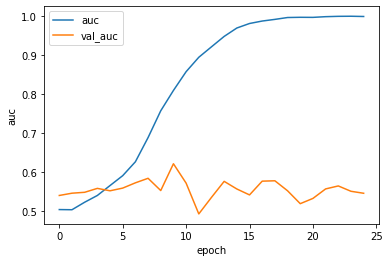

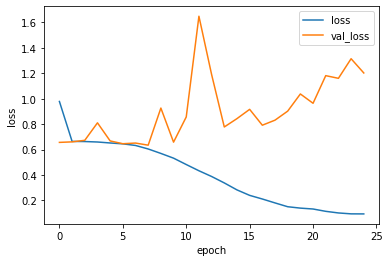

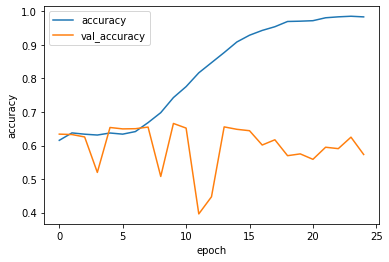

In [17]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [18]:
history.history

{'accuracy': [0.6155660152435303,
  0.6376768946647644,
  0.6338443160057068,
  0.6313384175300598,
  0.6373820900917053,
  0.6339917182922363,
  0.6416568160057068,
  0.6683372855186462,
  0.698113203048706,
  0.7430719137191772,
  0.7757959961891174,
  0.8169221878051758,
  0.8471403121948242,
  0.8773584961891174,
  0.9089033007621765,
  0.9290978908538818,
  0.9433962106704712,
  0.9544516801834106,
  0.9700766801834106,
  0.9709610939025879,
  0.9724351167678833,
  0.9811320900917053,
  0.9839327931404114,
  0.9857016801834106,
  0.9837853908538818],
 'auc': [0.5047242641448975,
  0.5043085217475891,
  0.5234915018081665,
  0.5407554507255554,
  0.5661201477050781,
  0.5913985371589661,
  0.6269044280052185,
  0.6887841820716858,
  0.7573245763778687,
  0.8092513680458069,
  0.8572639226913452,
  0.8940976858139038,
  0.9208437204360962,
  0.9474285244941711,
  0.9689188599586487,
  0.9804618954658508,
  0.9867457747459412,
  0.9909763932228088,
  0.9957515597343445,
  0.996318161

In [19]:
model.save('hateful_memes_v2.h5')

In [20]:
#make into a fn
bucket = 'jh_hateful_memes_test'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [21]:
def decode_example_testds(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'id': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 255.0
    label = single_example['id']
    return text, image, label

def no_tpu_output(text, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, image), label
    
    

In [22]:
def create_test_ds(files, batch_size=params['batch_size'], tpu=tpu, file_size=params['test_examples_per_file']):
    '''
    function to create dataset for test data
    ***clean up documentation for testds***
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        batch_size: int, batch size of training/validation step
        tpu: bool, default 'tpu' global variable, True is TPU is being used - not a bool update
        file_size: int, default num_examples_per_tfrecordfile variable,
            number of examples in each TFrecord file
    ***todo - update batch_size and file_size to params
    returns:
        ds: tensorflow input pipeline with images, text and labels
            if tpu is not None, output of ds is: text, image, label
            if tpu is None, output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
    ds = tf.data.TFRecordDataset(filenames = files)
    ds = ds.map(decode_example_testds, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #consider adding augmentation to image - can't flip(?)
    if tpu is None:
        ds = ds.map(no_tpu_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)
#     ds = ds.cache() # -- confirm if dataset is small enough to be cached
    
    ds_batches = (len(files) * file_size) // batch_size
    if (len(files) * file_size) % batch_size > 0:
        ds_batches += 1
    return ds, ds_batches
    
    

In [23]:
test_ds, test_steps = create_test_ds(tfrecords)

In [24]:
predictions = model.predict(test_ds, steps=test_steps)

In [25]:
prediction_ids = next(iter(test_ds.
                          map(lambda img, ids:ids).
                          unbatch().
                          batch(1000))).numpy().astype('str')

Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
prediction_dict = {
    'id': prediction_ids,
    'proba': np.concatenate(predictions),
    'label': np.ones(1000, int)
}
submission_ds = pd.DataFrame(prediction_dict)



In [27]:
submission_ds.to_csv('submission.csv', index=False)